In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/irf_model/')

from Dataset_Creation import sys_dataset
from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels


In [2]:
figformat = 'svg'

In [3]:
import json
with open("/home/katrin/Documents/nuisance_summary/E_reco/irf_model/config.json") as json_data_file:

    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}


In [4]:
biass = [0.0]
sigmass = [0.8]
sigma_assumed = 1e4

In [5]:
test = PowerLawSpectralModel()
print(test)

sky = SkyModel(spectral_model=test)

PowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm is_penalised link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ------------ ----
spectral     index 2.0000e+00                0.000e+00 nan nan  False   False        False     
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 0.000e+00 nan nan  False    True        False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False        False     


In [6]:
ereco = ERecoIRFModel()
print(ereco)

IRFmodels = IRFModels(e_reco_model= ereco,)

ERecoIRFModel

type    name      value    unit   error   min max frozen is_norm is_penalised link
---- ---------- ---------- ---- --------- --- --- ------ ------- ------------ ----
 irf       bias 0.0000e+00      0.000e+00 nan nan  False   False         True     
 irf resolution 0.0000e+00      0.000e+00 nan nan  False   False         True     


In [7]:
b = biass[0]; s = sigmass[0]

sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                    shift = 0,
                    tilt = 0,
                    bias = 0, 
                    sigma = s,
                    rnd = False,
                    e_reco_creation=10)
dataset_conv = sys_d_cor.create_dataset()
dataset_conv_N = sys_d_cor.create_dataset_N(1)
#dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
#dataset_conv_N.models.parameters['tilt_nuisance'].frozen  = True
dataset_conv_N.models.parameters['bias'].frozen  = True
#dataset_conv_N.models.parameters['resolution'].frozen  = True
#dataset_conv_N.models.parameters['resolution'].value  = s
dataset_conv_N.e_reco_n = 1

# new fine binned IRF Model
dataset_conv_N_fine =  sys_d_cor.create_dataset_N(100)

zero = 1e-12
penalising_invcovmatrix = np.zeros((2,2))
if b ==0 :
    b_ = zero
else:
    b_ = b
#np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/sigma_assumed**2])
#np.fill_diagonal(penalising_invcovmatrix, [1/b_**2, 1/sigma_assumed**2])
dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix


datasets_conv = Datasets([dataset_conv])
datasets_conv_N = Datasets([dataset_conv_N])
datasets_conv_N_fine = Datasets([dataset_conv_N_fine])




in map: 0.8
evaluate: 0.8 0.0
10
in map: 0.8
evaluate: 0.8 0.0
10
in map: 0.8
evaluate: 0.8 0.0
10


In [8]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

in map: 0.0
evaluate: 0.0 0.0
1


<WCSAxesSubplot: >

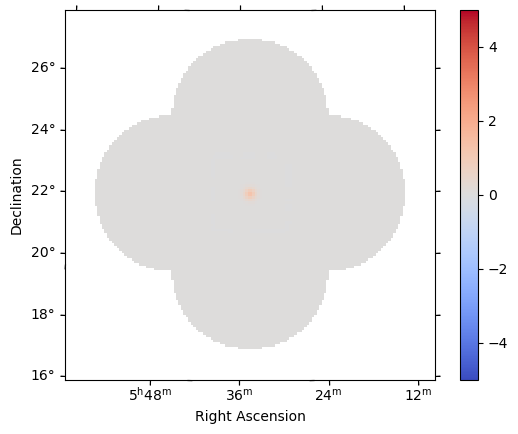

In [9]:
d = dataset_conv_N
d.plot_residuals_spatial()

in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
100


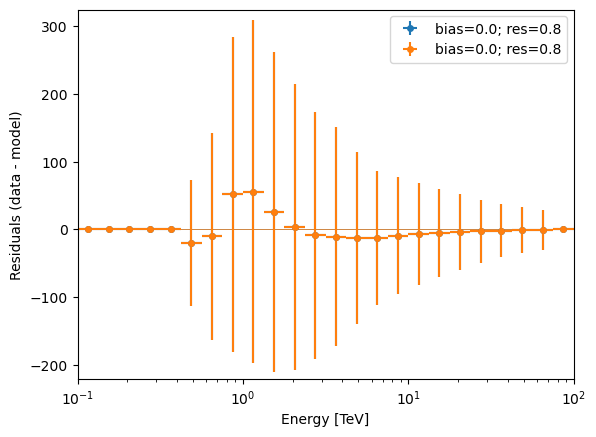

In [10]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        d = datasets_conv_N_fine[i]
        d.plot_residuals_spectral(ax =ax, color= colors[1], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
100
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
100


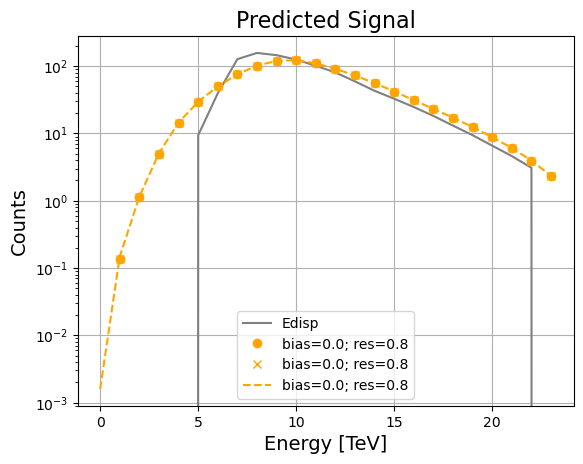

In [11]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
npreds_pre_fit = []
npreds_pre_fit_N = []
npreds_pre_fit_N_fine = []
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        npreds_pre_fit_N_fine.append( sum_e(datasets_conv_N_fine[i].npred_signal().data))
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N_fine[i].npred_signal().data),
                 '--', label = f"bias={b}; res={s}", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 548              │
│ EDM = 4.59e-05 (Goal: 2e-06)     │            time = 6.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.048981650550496525
evaluate: -0.048981650550496525 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.048981650550496525
evaluate: -0.048981650550496525 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.048981650550496525
evaluate: -0.048981650550496525 0.0
1
in map: -0.08406712597641885
evaluate: -0.08406712597641885 0.0
1
in map: -0.048981650550496525
evaluate: -0.048981650550496525 0.0
1
in map: -0.048981650550496525
evaluate: -0.048981650550496525 0.0
1
in map: -0.04765516647203483
evaluate: -0.04765516647203483 0.0
1
in map: -0.042384427735864524
evaluate: -0.042384427735864524 0.0


1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.03602924545186016
evaluate: -0.03602924545186016 0.0
1
in map: -0.026129050807676104
evaluate: -0.026129050807676104 0.0
1
in map: -0.045929440096044216
evaluate: -0.045929440096044216 0.0
1
in m

in map: -0.031135041936206587
evaluate: -0.031135041936206587 0.0
1
in map: -0.031135041936206587
evaluate: -0.031135041936206587 0.0
1
in map: -0.031135041936206587
evaluate: -0.031135041936206587 0.0
1
in map: 0.023142189348852614
evaluate: 0.023142189348852614 0.0
1
in map: -0.0854122732212658
evaluate: -0.0854122732212658 0.0
1
in map: 1.6207374641021484
evaluate: 1.6207374641021484 0.0
1
in map: 0.055699634627422195
evaluate: 0.055699634627422195 0.0
1
in map: 0.005045726530851648
evaluate: 0.005045726530851648 0.0
1
in map: -0.013278636239100153
evaluate: -0.013278636239100153 0.0
1
in map: -0.02223315847592824
evaluate: -0.02223315847592824 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0


1
in map: -0.024124429553796865
evaluate: -0.024124429553796865 0.0
1
in map: -0.024219819149486246
evaluate: -0.024219819149486246 0.0
1
in map: -0.024266546492049592
evaluate: -0.024266546492049592 0.0
1
in map: -0.02428940402248266
evaluate: -0.02428940402248266 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.02431

in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1
in map: -0.012080919378693135
evaluate: -0.012080919378693135 0.0
1
in map: -0.03654207285264093
evaluate: -0.03654207285264093 0.0
1
in map: -0.021865380768272255
evaluate: -0.021865380768272255 0.0
1
in map: -0.02675761146306181
evaluate: -0.02675761146306181 0.0
1
in map: -0.02382227304618808
evaluate: -0.02382227304618808 0.0
1
in map: -0.024800719185145988
evaluate: -0.024800719185145988 0.0
1
in map: -0.024213651501771242
evaluate: -0.024213651501771242 0.0
1
in map: -0.024409340729562825
evaluate: -0.024409340729562825 0.0
1
in map: -0.024311496115667033
evaluate: -0.02431149611

'fit_cor_N_fine = Fit(store_trace=True)\nfit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}\nresult_cor_N_fine = fit_cor_N_fine.run(datasets_conv_N_fine)\ndatasets_conv_N_fine.models.covariance = fit_cor_N_fine.covariance(datasets_conv_N_fine).matrix\ndatasets_conv_N_fine.models.covariance.plot_correlation()\nprint(fit_cor_N_fine.minuit)'

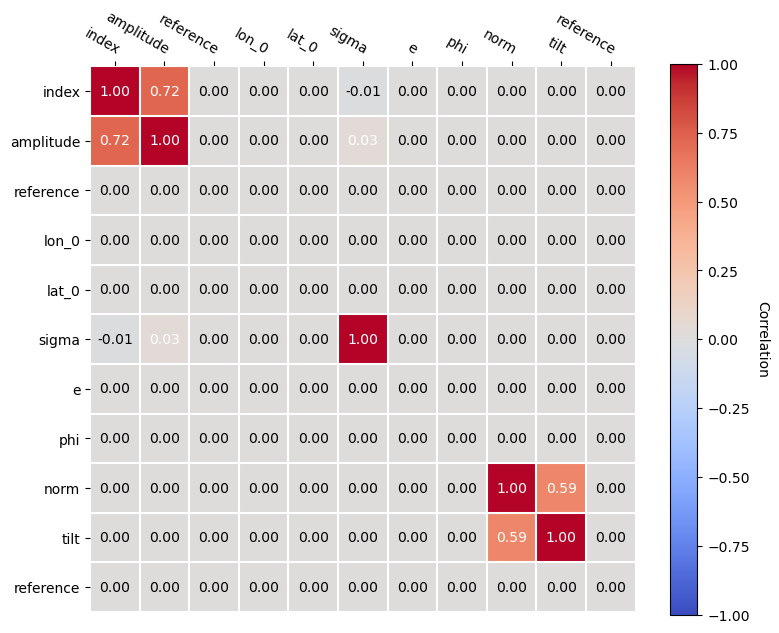

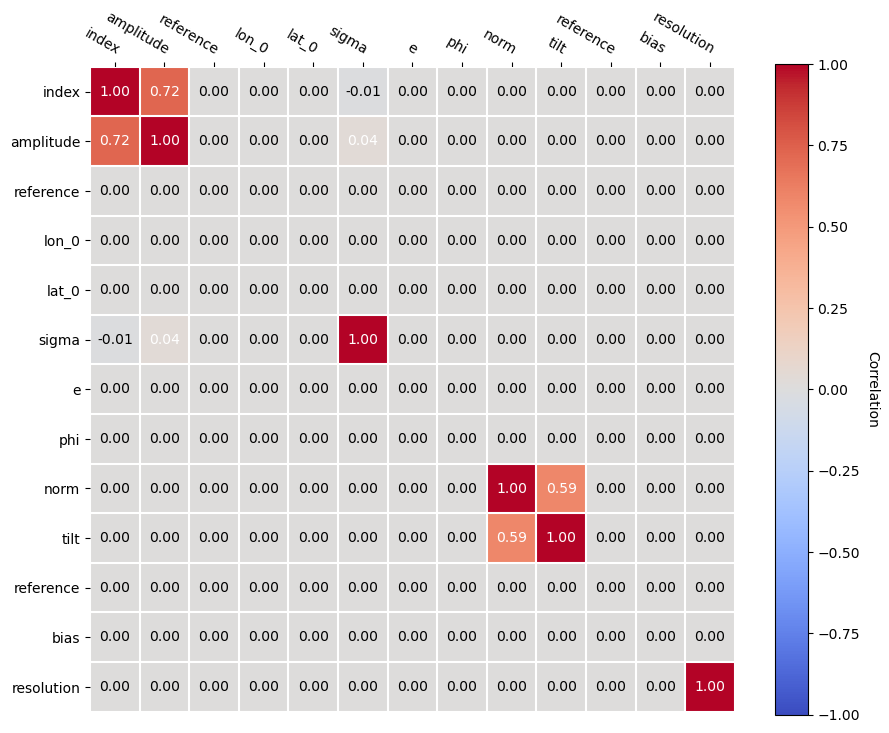

In [12]:
%%time
print("corr")
fit_cor = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run(datasets_conv)
datasets_conv.models.covariance = fit_cor.covariance(datasets_conv).matrix
datasets_conv.models.covariance.plot_correlation()
print(fit_cor.minuit)

fit_cor_N = Fit(store_trace=True)
fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
result_cor_N = fit_cor_N.run(datasets_conv_N)
datasets_conv_N.models.covariance = fit_cor_N.covariance(datasets_conv_N).matrix
datasets_conv_N.models.covariance.plot_correlation()
print(fit_cor_N.minuit)
    
'''fit_cor_N_fine = Fit(store_trace=True)
fit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}
result_cor_N_fine = fit_cor_N_fine.run(datasets_conv_N_fine)
datasets_conv_N_fine.models.covariance = fit_cor_N_fine.covariance(datasets_conv_N_fine).matrix
datasets_conv_N_fine.models.covariance.plot_correlation()
print(fit_cor_N_fine.minuit)'''



        

In [13]:
'''for p in datasets_conv_N.models.parameters.penalised_parameters:
    p.frozen = True
    print(p.name)
        
for p in datasets_conv_N_fine.models.parameters.penalised_parameters:
    p.frozen = True
    print(p.name)'''

'for p in datasets_conv_N.models.parameters.penalised_parameters:\n    p.frozen = True\n    print(p.name)\n        \nfor p in datasets_conv_N_fine.models.parameters.penalised_parameters:\n    p.frozen = True\n    print(p.name)'

In [14]:
colors_standard = ['darkblue', 'sienna', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


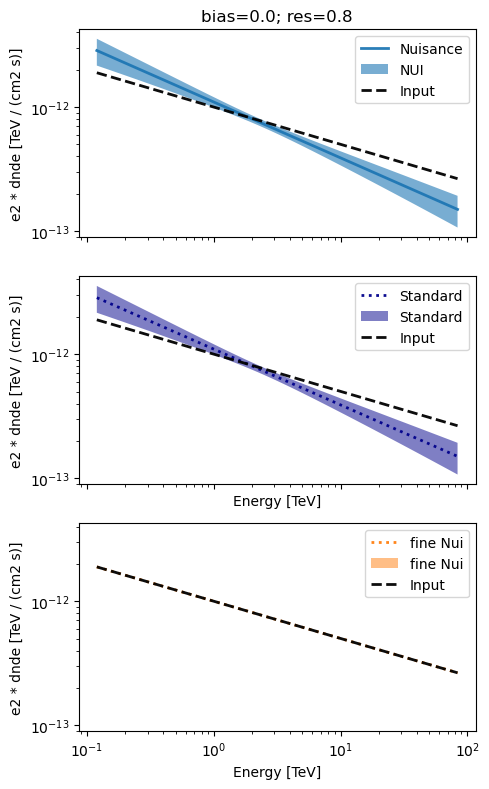

In [15]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


fig,axs = plt.subplots(3,1, sharex = True, sharey=True, figsize = (5,8))
#axs = [axs]
i =0; ii =0
for b in biass:
    for s in sigmass:
        
        d = datasets_conv_N
    
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               color=colors_standard[ii],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               facecolor=colors_standard[ii],
                                                                 label="Standard",
                                                                alpha = 0.5)
        
        d = datasets_conv_N_fine
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               color=colors[ii+1],
                                                                 label= f"fine Nui",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               facecolor=colors[ii+1],
                                                                 label="fine Nui",
                                                                alpha = 0.5)
        
        axs[ii].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for a in axs:
    dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
    a.legend()
    
ylim = axs[0].get_ylim()
axs[0].set_xlabel('')
plt.tight_layout()


in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1


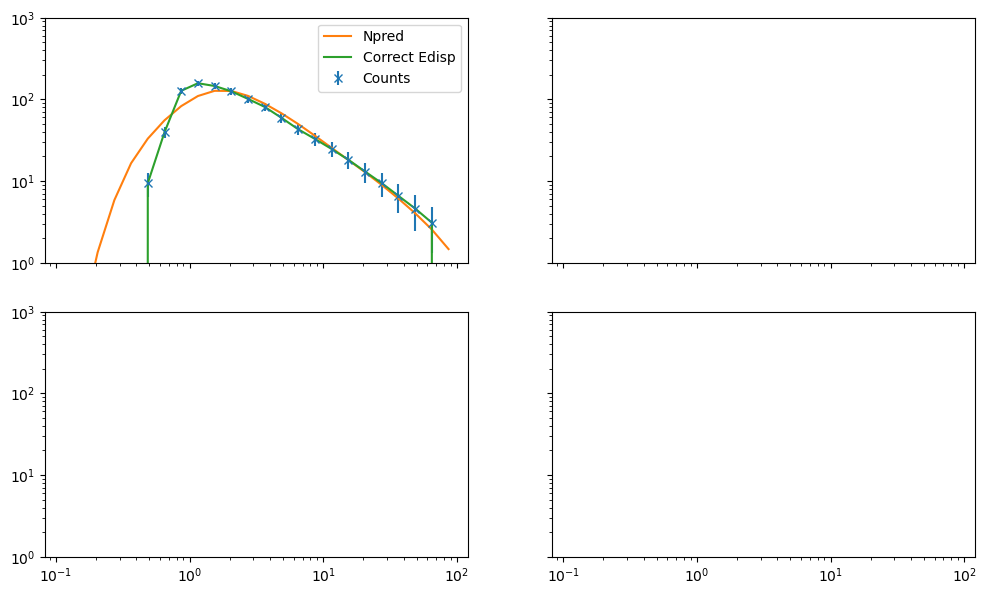

In [16]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].plot(energy, sum_e(dataset_load.npred_signal().data), label = "Correct Edisp")
        
        
        
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1


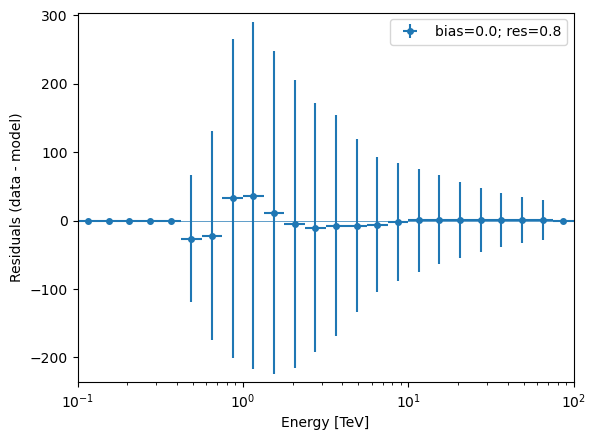

In [17]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


['Standard', 'B=0.0;\n R=0.8;\n nbin =1', 'B=0.0;\n R=0.8;\n nbin =10']


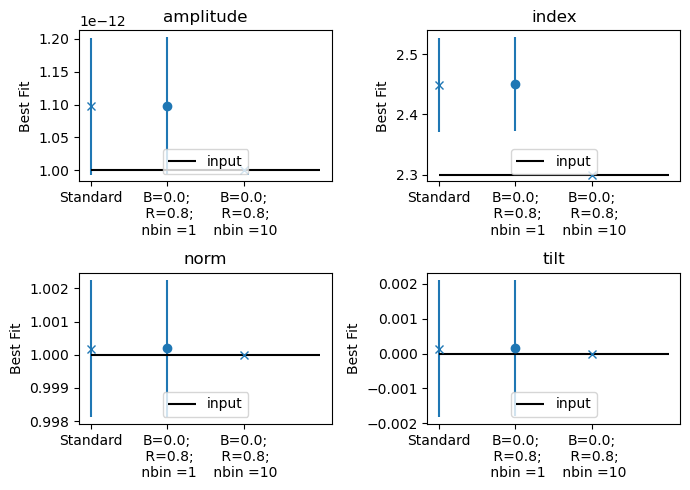

In [18]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = colors[ii])
        labels_sys.append(f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(1, value, yerr = error, fmt = 'o', color = colors[ii])
        labels_sys.append(f'B={b};\n R={s};\n nbin =1')
            
        d = datasets_conv_N_fine[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(2, value, yerr = error, fmt = 'x', color = colors[ii])
        labels_sys.append(f'B={b};\n R={s};\n nbin =10')
            
        ii +=1
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys), label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
    

['B=0.0;\n R=0.8;\n nbin =1', 'B=0.0;\n R=0.8;\n nbin =10']


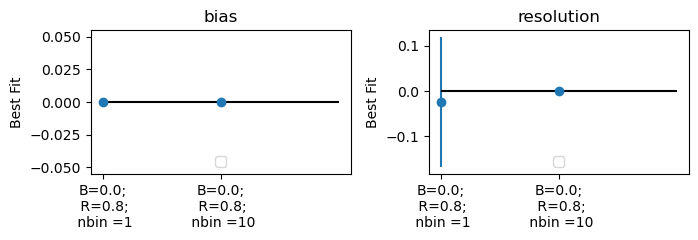

In [19]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)
        labels_sys.append(f'B={b};\n R={s};\n nbin =1')
            
        d = datasets_conv_N_fine[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(1, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)    
            
        ii +=1
        labels_sys.append(f'B={b};\n R={s};\n nbin =10')
        
        
print(labels_sys)        
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    ax.hlines( 0, 0., len(labels_sys), label = "input", color= 'black')
    
plt.tight_layout()
    

in map: -0.024311496115667033
evaluate: -0.024311496115667033 0.0
1


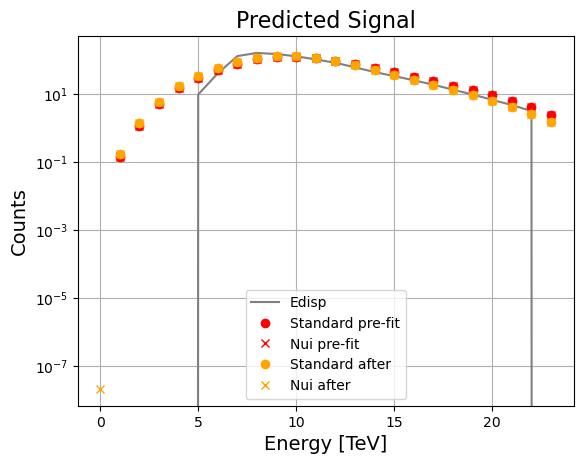

In [20]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
for b in biass:
    for s in sigmass:
        plt.plot( npreds_pre_fit[i],
                 fmts[i], label = f"Standard pre-fit", color = colors[i+1])
        plt.plot( npreds_pre_fit_N[i],
                 'x', label = f"Nui pre-fit", color = colors[i+1])
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"Standard after", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"Nui after", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

In [21]:
sdf

NameError: name 'sdf' is not defined

## Statscan

In [ ]:
grid = np.linspace(-0.3, 0.3, 11)

!!! NOT THE CORRECT PARAMETERS ARE GETTING SCANED HERE!!!

 WAS THE PROBLEM THAT THE RESOLUTION IS FROZEN?  ---> yes :(

In [ ]:
%%time
x_N, y_N , s_N= fit_cor_N.minuit.mnprofile("par_005_resolution",grid=grid)
#x_N_fine, y_N_fine , s_N_fine= fit_cor_N_fine.minuit.mnprofile("par_005_resolution", grid=grid)


In [ ]:
plt.plot(x_N, y_N)
#plt.plot(x_N_fine, y_N_fine , label = 'fine')
plt.legend()

## Test the same for the other parameters

In [ ]:
grid_index = np.linspace(2, 2.5, 11)

In [ ]:
print(datasets_conv_N[0].models)

In [ ]:
%%time
x_N_index, y_N_index , s_N_index= fit_cor_N.minuit.mnprofile("par_000_index",grid=grid_index)
x_index, y_index , s_index= fit_cor.minuit.mnprofile("par_000_index", grid=grid_index)


In [ ]:
plt.plot(x_index, y_index)
plt.plot(x_N_index, y_N_index , label = 'Nuisance')
plt.legend()

In [ ]:
grid = np.linspace(-0.3, 0.3, 11)

In [ ]:
%%time
par =dataset_conv_N.models.parameters['index']
par.scan_values = grid_index
stat  = fit_cor_N.stat_profile(
    datasets = datasets_conv_N,
    parameter = par,
    reoptimize = True)




In [ ]:
print('fine')
par_standard =dataset_conv.models.parameters['index']
par_standard.scan_values = grid_index
stat_standard  = fit_cor.stat_profile(
    datasets = datasets_conv,
    parameter = par_standard,
    reoptimize=True)

In [ ]:
plt.plot(stat['Source.spectral.index_scan'],stat['stat_scan'] )
plt.plot(stat_standard['Source.spectral.index_scan'],stat_standard['stat_scan'], label = 'standard' )
plt.plot(x_N_index, y_N_index , label = 'Nuisance')

plt.legend()